In [1]:
import torchvision.models as models
from torch.nn import Parameter
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
from glob import glob

import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [2]:
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=False):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.Tensor(1, 1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight) #18x1024
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class AnaXnetGCN(nn.Module):
    def __init__(self, num_classes, anatomy_size=18, in_channel=1024):
        super(AnaXnetGCN, self).__init__()
        anatomy_out = 1024
        self.num_classes = num_classes

        self.anatomy_gc1 = GraphConvolution(in_channel, 2048)
        self.anatomy_gc2 = GraphConvolution(2048, 1024)

        self.relu = nn.LeakyReLU(0.2)
        self.softmax = nn.Softmax(dim=2)

        # self.fc = nn.Linear((findings_out+anatomy_out), num_classes)
        self.fc = nn.Sequential(
            nn.LayerNorm(anatomy_out),
            nn.AdaptiveAvgPool2d((anatomy_size, anatomy_out)),
            nn.Linear(anatomy_out, num_classes)
        )

        #anatomy adjacency matrix
        self.anatomy_inp_tensor = Parameter(torch.FloatTensor(torch.ones((anatomy_size, anatomy_size))))

    def anatomy_gcn(self, feature):
        anatomy_inp = feature
        adj = self.anatomy_inp_tensor.detach() 
        x = self.anatomy_gc1(anatomy_inp, adj)
        x = self.relu(x)
        x = self.anatomy_gc2(x, adj)

        x = x.transpose(1, 2)
        x = torch.matmul(feature, x)
        x = self.softmax(x)
        x = torch.matmul(x, anatomy_inp)
        return x

    def forward(self, feature):
        anatomy = self.anatomy_gcn(feature)
        anatomy = anatomy.add(feature)
        anatomy = self.fc(anatomy)
        return anatomy

In [3]:
# 8 graphs
# 18 nodes per graph
# 1024 features per node
node_feats = torch.randn(8, 18, 1024)

model = AnaXnetGCN(14)
output = model(node_feats)
output.shape

torch.Size([8, 18, 14])

In [4]:
import pandas as pd
import numpy as np
import os
from glob import glob
import shutil
import json
from PIL import Image
import random
from tqdm import tqdm

In [5]:
class coco_format():
    def __init__(self) -> None:
        
        self.organs = ["right lung", "right apical zone", "right upper lung zone", "right mid lung zone", 
            "right lower lung zone", "right hilar structures", "right costophrenic angle", "left lung", "left apical zone",
            "left upper lung zone", "left mid lung zone", "left lower lung zone", "left hilar structures", 
            "left costophrenic angle", "mediastinum", "upper mediastinum", "cardiac silhouette", "trachea"]
        
        self.diseaselist = ['lung opacity', 'pleural effusion', 'atelectasis', 'enlarged cardiac silhouette',
        'pulmonary edema/hazy opacity', 'pneumothorax', 'consolidation', 'fluid overload/heart failure', 'pneumonia']
       
        self.scene_graphs_dir = '/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/scene_graph'
        self.outputdir = "/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset"
        
        print('Disease length is {}'.format(str(len(self.diseaselist))))

        #obtain list of train, valid, test files
        self.my_data = sorted(glob(f'{self.scene_graphs_dir}/*.json'))

    def generate_data(self):  
        images = []
        categories = []
        count = 0
        coco_data = {}
        imagesID = []
        labels = []
        for filename in tqdm(self.my_data):
            image_json = {}
            annotations = []
            if 'DS_Store' not in filename:
                count += 1
                hasattributes = 0
                # print('Processing file {}'.format(str(count)))
                try:
                    f = open(str(filename),) 
                except FileNotFoundError:
                    print('{} not in directory'.format(filename))
                else:
                    data = json.load(f)
                    imageID = data['image_id']
                    ids = [obj['object_id'] for obj in data['objects']]
                    ignore = 0
                    hasdisease = 1
                    for objects in data['objects']:
                        hasdisease = 1
                        # objectID = attribute['object_id']
                        row = np.zeros([len(self.diseaselist)])
                        if objects['object_id'].split('_')[1] in self.organs:
                            annotation_json = {}
                            for attribute in data['attributes']:
                                if attribute['object_id'] == objects['object_id']:
                                    for diseases in attribute['attributes']:
                                        for disease in diseases:                                                
                                            if disease.split('|')[2] in self.diseaselist:
                                                hasdisease = 1
                                                hasattributes = 1
                                                class_index = self.diseaselist.index(disease.split('|')[2])
                                                if disease.split('|')[1] == 'yes':
                                                    row[class_index] = int(1)
                                                else:
                                                    row[class_index] = int(0)
                                annotation_json['id'] = objects['object_id']
                                annotation_json['category_id'] = self.organs.index(objects['object_id'].split('_')[1])
                                annotation_json['iscrowd'] = 0
                                annotation_json["bbox_mode"] = 1
                                annotation_json['image_id'] = data['image_id']
                                int_row = row.astype(int)
                                annotation_json['attributes'] = int_row.tolist()
                                annotation_json['bbox'] = [objects['original_x1'], objects['original_y1'],
                                objects['original_width'], objects['original_height']]
                                annotations.append(annotation_json)
            
                    image_json['image_id'] = data['image_id']
                    myfile = str(data['image_id']) + '.jpg'
                    image_json['file_name'] = myfile
                    # path = os.path.join(self.imageroot, myfile) #"./VG/data/" + myfile
                    # im = Image.open(path)
                    # image_json['width'], image_json['height'] = im.size
                    image_json['annotations'] = annotations
                    # # imagesID.append(myfile)
                    images.append(image_json)
    
        save_file_name = "xray_coco_all.json"
        filename = os.path.join(self.outputdir, save_file_name)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(images, f, ensure_ascii=False, indent=4)            
        
# x_ray_coco = coco_format()
# x_ray_coco.generate_data()

In [6]:
import pandas as pd
import numpy as np
import os
import shutil
import json
import statistics
from PIL import Image
import random
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import jaccard_score

class AdjacencyMatrices():
    def __init__(self) -> None:
        self.filename = '/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/mimic_coco_filtered.json'
        self.outputdir = "/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset"
        self.diseaselist = ['lung opacity', 'pleural effusion', 'atelectasis', 'enlarged cardiac silhouette',
        'pulmonary edema/hazy opacity', 'pneumothorax', 'consolidation', 'fluid overload/heart failure', 'pneumonia']

        self.organs = ["right lung", "right apical zone", "right upper lung zone", "right mid lung zone", 
        "right lower lung zone", "right hilar structures", "right costophrenic angle", "left lung", "left apical zone",
        "left upper lung zone", "left mid lung zone", "left lower lung zone", "left hilar structures", 
        "left costophrenic angle", "mediastinum", "upper mediastinum", "cardiac silhouette", "trachea"]

        print("Loading json data ...")
        with open(str(self.filename),) as f:
            self.data = json.load(f)
        self.data_size = len(self.data)
        print(self.data_size)
        print("Done loading json data ...")
        

    '''
    The Similarity measure between each pair of anatomy objects A and B
    Jaccard similarity measure is used to measure the similarity between 
    each object, by measuring the average similarity over every disease class
    '''
    def anatomy(self):
        error = 1e-9
        anatomy_len = len(self.organs)
        row = self.organs
        column = self.organs
        adj_matrix = []

        for ind, B in enumerate(row):
            print("Processing {} from row {}".format(B, str(ind)))
            rows = np.zeros([len(self.organs)]) 
            for inde, A in enumerate(tqdm(column)):
                # print("Processing {} from column {}".format(A, str(inde)))
                AnB_count = 0
                B_count = 0
                row_counter = Counter()
                column_counter = Counter()
                a_val = []
                b_val = []
                p_anb = 0
                
                for img in self.data:
                    ids = [self.organs[int(obj['category_id'])] for obj in img['annotations']]
                    aa = []
                    bb = []
                    if set(ids) == set(self.organs):
                        for relation in img['annotations']:
                            if int(relation['category_id']) == ind:
                                bb = relation['attributes']
                        for relations in img['annotations']:
                            if int(relations['category_id']) == inde:
                                aa = relations['attributes']
                        if np.count_nonzero(np.array(aa)) > 0 or np.count_nonzero(np.array(bb)) > 0:
                            b_val.append(bb)
                            a_val.append(aa)
                    else:
                        continue

                df_A = pd.DataFrame(a_val, columns=self.diseaselist)
                df_B = pd.DataFrame(b_val, columns=self.diseaselist)
                
                assert len(b_val) == len(a_val)
                
                if not df_A.empty:
                    jaccard_list = []
                    for disease in self.diseaselist:
                        jaccard = jaccard_score(df_B[disease], df_A[disease], average='macro')
                        jaccard_list.append(jaccard)
                    p_anb = statistics.mean(jaccard_list)

                if ind == inde:
                    p_anb = 1
                if p_anb > 0.5:
                    p_anb = 1
                else:
                    p_anb = 0
                
                rows[inde] = p_anb
            adj_matrix.append(rows.tolist())

        
        df = pd.DataFrame(adj_matrix, columns=self.organs)
        # print(df)
        filename = os.path.join(self.outputdir, 'anatomy_matrix.csv')
        df.to_csv(filename, sep='\t', index=False)
        return df

matrix = AdjacencyMatrices()
# anatomy = matrix.anatomy()

Loading json data ...
231528
Done loading json data ...


In [7]:
len(matrix.data), type(matrix.data), len(matrix.data[0]), type(matrix.data[0])

(231528, list, 3, dict)

In [8]:
# new_image_data = []

# for img in tqdm(matrix.data):
#     annotations = []
#     track_ids = []
#     for annotation in img['annotations']:
#         if annotation['id'] not in track_ids:
#             track_ids.append(annotation['id'])
#             annotations.append(annotation)

#     img['annotations'] = annotations
#     new_image_data.append(img)

# save_file_name = "xray_coco_all_filtered.json"
# filename = os.path.join(matrix.outputdir, save_file_name)
# with open(filename, 'w', encoding='utf-8') as f:
#     json.dump(new_image_data, f, ensure_ascii=False, indent=4)  

In [9]:
all_image_files = sorted(glob(f'/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/mimic-cxr-jpg/2.0.0/files/**/*.jpg', recursive=True))
len(all_image_files)

373762

In [10]:
all_image_ids = [fname.split('/')[-1].split('.')[0] for fname in tqdm(all_image_files)]

100%|██████████| 373762/373762 [00:00<00:00, 1197987.95it/s]


In [11]:
sample_data = matrix.data[0]
sample_data['image_id'], sample_data['file_name']

('000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d',
 '000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d.jpg')

In [12]:
img_file_location = all_image_files[all_image_ids.index(sample_data['image_id'])]
img_file_location

'/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10934092/s55245226/000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d.jpg'

In [13]:
set_image_ids = set(all_image_ids)

In [14]:
# new_image_data = []

# count = 0
# with tqdm(matrix.data) as pbar:
#     for i, img in enumerate(pbar):
#         if img['image_id'] not in set_image_ids:
#             count += 1
#             pbar.set_postfix({'Files not found': count})
#         else:
#             new_image_data.append(img)

# save_file_name = "mimic_coco_all.json"
# filename = os.path.join(matrix.outputdir, save_file_name)
# with open(filename, 'w', encoding='utf-8') as f:
#     json.dump(new_image_data, f, ensure_ascii=False, indent=4)  

In [15]:
sample_data = matrix.data[0]

In [16]:
l1 = [annotation['id'].split('_')[-1] for annotation in sorted(sample_data['annotations'], key=lambda k: k['category_id'])]

In [17]:
df = pd.read_csv(os.path.join(matrix.outputdir, 'anatomy_matrix.csv'), sep='\t')
l2 = df.columns.to_list()

In [18]:
# temp_image_data = []

# count = 0
# with tqdm(new_image_data) as pbar:
#     for i, img in enumerate(pbar):
#         l1 = [annotation['id'].split('_')[-1] for annotation in sorted(img['annotations'], key=lambda k: k['category_id'])]
#         if l1 != l2:
#             count += 1
#             pbar.set_postfix({'Files with missing nodes': count, 'Missing node count': len(l2)-len(l1)})
#         else:
#             temp_image_data.append(img)

# save_file_name = "mimic_coco_filtered.json"
# filename = os.path.join(matrix.outputdir, save_file_name)
# with open(filename, 'w', encoding='utf-8') as f:
#     json.dump(temp_image_data, f, ensure_ascii=False, indent=4)  

In [21]:
image_file_location = all_image_files[all_image_ids.index(sample_data['image_id'])]
image_file_location

'/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10934092/s55245226/000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d.jpg'

In [24]:
import torchvision.transforms as transforms

In [114]:
my_transforms = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                         std=[0.229, 0.224, 0.225])
])

In [115]:
img = Image.open(image_file_location)
img.size

(3050, 2539)

In [116]:
sub_anatomies = []
sub_anatomy_labels = []

for annotation in sorted(sample_data['annotations'], key=lambda k: k['category_id']):
    # print(annotation['id'].split('_')[-1], annotation['category_id'], annotation['attributes'])
    x, y, w, h = annotation['bbox']
    sub_anatomy = img.crop((x, y, x+w, y+h))
    sub_anatomy = my_transforms(sub_anatomy)
    sub_anatomies.append(sub_anatomy)
    sub_anatomy_labels.append(annotation['id'].split('_')[-1])

In [117]:
sub_anatomies = torch.stack(sub_anatomies)
sub_anatomies.shape

torch.Size([18, 3, 224, 224])

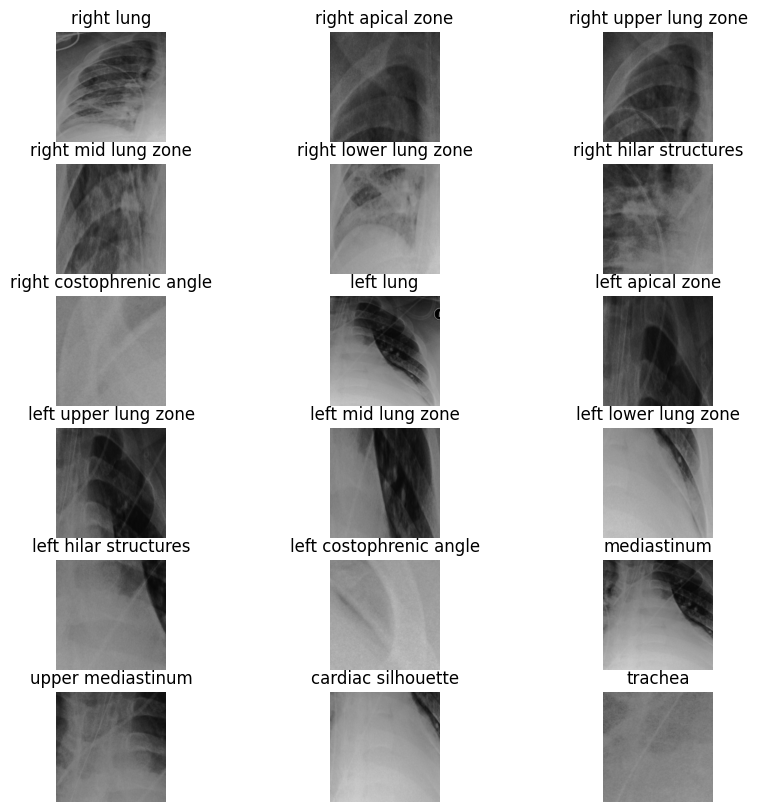

In [119]:
# plot all 18 images from sub_anatomies
fig = plt.figure(figsize=(10, 10))
for i in range(18):
    plt.subplot(6, 3, i+1)
    plt.imshow(sub_anatomies[i].permute(1, 2, 0))
    plt.title(sub_anatomy_labels[i])
    plt.axis('off')

In [138]:
temp_df = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-split.csv')
temp_df.rename(columns={'dicom_id': 'image_id'}, inplace=True)
temp_df

,image_id,study_id,subject_id,split
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,train
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,train
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train
...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,57132437,19999733,train
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,57132437,19999733,train
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,55368167,19999987,train
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,58621812,19999987,train


In [139]:
my_df = pd.DataFrame(matrix.data)
my_df = my_df.merge(temp_df, on='image_id', how='left')
my_df

,image_id,file_name,annotations,study_id,subject_id,split
0,000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d,000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d.jpg,[{'id': '000046e4-e4d7f796-72c3dba4-8b67a485-0...,55245226,10934092,train
1,00005197-869d72f3-66210bf4-fa2c9d83-b613c4e7,00005197-869d72f3-66210bf4-fa2c9d83-b613c4e7.jpg,[{'id': '00005197-869d72f3-66210bf4-fa2c9d83-b...,59116935,14851532,test
2,00009bca-0893e5e4-c1296676-181f5233-25dfa9a3,00009bca-0893e5e4-c1296676-181f5233-25dfa9a3.jpg,[{'id': '00009bca-0893e5e4-c1296676-181f5233-2...,58246830,15342241,train
3,0000c2f5-f02f9f3c-1ed14642-958de0ad-d6ce4d20,0000c2f5-f02f9f3c-1ed14642-958de0ad-d6ce4d20.jpg,[{'id': '0000c2f5-f02f9f3c-1ed14642-958de0ad-d...,56580856,17744443,train
4,0000d3be-591ae3b7-b03a7497-8319c02b-650bb4ab,0000d3be-591ae3b7-b03a7497-8319c02b-650bb4ab.jpg,[{'id': '0000d3be-591ae3b7-b03a7497-8319c02b-6...,50189753,19298916,train
...,...,...,...,...,...,...
231523,ffff24b1-3d02ec5a-a30b719c-51c08fa7-41664323,ffff24b1-3d02ec5a-a30b719c-51c08fa7-41664323.jpg,[{'id': 'ffff24b1-3d02ec5a-a30b719c-51c08fa7-4...,58158688,15179179,train
231524,ffff2d79-a7dad5a6-1e5d9f94-efddd0b3-29ad204b,ffff2d79-a7dad5a6-1e5d9f94-efddd0b3-29ad204b.jpg,[{'id': 'ffff2d79-a7dad5a6-1e5d9f94-efddd0b3-2...,57186535,15312163,train
231525,ffff4375-7e946518-9955f47c-72492046-f47a6c52,ffff4375-7e946518-9955f47c-72492046-f47a6c52.jpg,[{'id': 'ffff4375-7e946518-9955f47c-72492046-f...,51255235,11486239,train
231526,ffff5313-458549ff-8ef54533-add9597f-a0db64b7,ffff5313-458549ff-8ef54533-add9597f-a0db64b7.jpg,[{'id': 'ffff5313-458549ff-8ef54533-add9597f-a...,55017920,14924200,train


In [151]:
from torch.utils.data import DataLoader
from dataloader.anaxnet import CustomDataset

In [154]:
test_dataset = CustomDataset(my_df, split='test')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=10)

In [155]:
from model.anaxnet import CustomModel

device = 'cuda'
model = CustomModel({'lr': 4e-6}, num_classes=9)
model = model.to(device)

/home2/arihanth.srikar/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [156]:
with torch.no_grad():
    for i, (node_feats, y) in enumerate(tqdm(test_loader)):
        node_feats = node_feats.to(device)
        y = y.float().to(device)
        
        node_feats, loss = model(node_feats, y)
        print(node_feats.shape, loss.item())

        break

  0%|          | 0/399 [00:00<?, ?it/s]

torch.Size([8, 18, 9]) 0.7086375951766968


  0%|          | 0/399 [00:03<?, ?it/s]
